# Data overview
This notebook explores our data to understand the collaboration patterns between EUTOPIA institutions. We will focus on the following aspects:
1. Articles by affiliation: We will show out of all processed articles from EUTOPIA-affiliated institutions, how many have been affiliated with certain university. We filter out articles with unknown affiliation and sort the results by the total number of articles.
2. Collaboration funnel: We will show the number of articles in a funnel visualization. We show the total number of articles, how many of them are collaborations, how many of them are EUTOPIAan collaborations and how many of them are both.
3. Publication trends: We will show the publication trends of EUTOPIA institutions. We show how many articles have been published by EUTOPIA institutions each year, how many of them have been collaborations and how EUTOPIAan collaborations are trending.


## Brief overview
In this thesis, we will be analyzing only articles published by EUTOPIA institutions, which includes *416K* unique articles written in collaboration between *545K* unique authors. More than half articles have at least one author from a non-EUTOPIA affiliation. There are also significant differences in publication frequency between institutions, for example *Dresden University of Technology* has significantly more articles (*75K*) than *CY Cergy Paris University* (*9K*). Looking at collaboration funnel, we see that most articles are collaborations and a major part of collaborations are authored by multiple institutions. Within the EUTOPIA organization the bottleneck of collaboration is not collaborating with other institutions but specifically collaborating with other EUTOPIA institutions. We assume that authors are not familiar with research groups formed within EUTOPIA institutions, which drops the proportion of EUTOPIA collaborations to $1.77\%$. We conclude that researchers often collaborate with external authors and if our recommender system can help authors find appropriate research teams within the EUTOPIA organization, there is lots of untapped potential for the development of this cross-institutional partnership. The goal of this thesis is to drive the distribution of articles over affiliations closer to a uniform distribution.

We see how the number of articles and collaborations increase over time. This very well corresponds with the dogma ”publish or perish” and the research explosion we are seeing across many areas that are getting more financing in past years. We can observe a similar trend in computer science publications via [dblp](https://dblp.org/statistics/recordsindblp.html).

## Global imports & settings


In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import seaborn as sns
import matplotlib.pyplot as plt

from box import Box
from util.postgres import create_sqlalchemy_connection, query

In [2]:

# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize Postgres
pg_conn = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
# Set the Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

### Read main fact table

Read the main fact table and store data in a DataFrame.

In [3]:
# Define the SQL query
df = query(
    conn=pg_conn,
    query_str=f"""
        SELECT COUNT(DISTINCT author_id)  AS authors,
               COUNT(DISTINCT article_id) AS articles
        FROM fct_collaboration
    """
)

print(f'Authors: {df["authors"][0]:,}')
print(f'Articles: {df["articles"][0]:,}')

Authors: 545,297
Articles: 416,085


### Process the data
1. Query the data from PostgreSQL
3. Compute the number of articles for each affiliation
4. Compute the percentage of each article type for each affiliation

In [4]:
# Define the SQL query
sql_query = f"""
SELECT institution_id
     , COUNT(DISTINCT article_id)                                                   AS total_articles
     , COUNT(DISTINCT CASE WHEN is_single_author_collaboration THEN article_id END) AS single_author_collaboration
     , COUNT(DISTINCT CASE WHEN is_internal_collaboration THEN article_id END)      AS internal_collaboration_articles
     , COUNT(DISTINCT CASE WHEN is_external_collaboration THEN article_id END)      AS external_collaboration_articles
     , COUNT(DISTINCT CASE WHEN is_eutopia_collaboration THEN article_id END)       AS eutopian_collaboration_articles
FROM fct_collaboration c
GROUP BY 1
ORDER BY 2 ASC
"""

# Execute the query and store the result in a DataFrame
query_job = query(conn=pg_conn, query_str=sql_query)
institution_df = query_job.set_index('institution_id')

# Compute percentages for the 100% stacked bar plot
institution_df['Single Author Articles'] = institution_df['single_author_collaboration'] / institution_df['total_articles'] * 100
institution_df['Internal Collaboration Articles'] = institution_df['internal_collaboration_articles'] / institution_df[
    'total_articles'] * 100
institution_df['External Collaboration Articles'] = institution_df['external_collaboration_articles'] / institution_df[
    'total_articles'] * 100

### Plotting
We plot the number of articles for each affiliation and the percentage of each article type for each affiliation using two subplots.

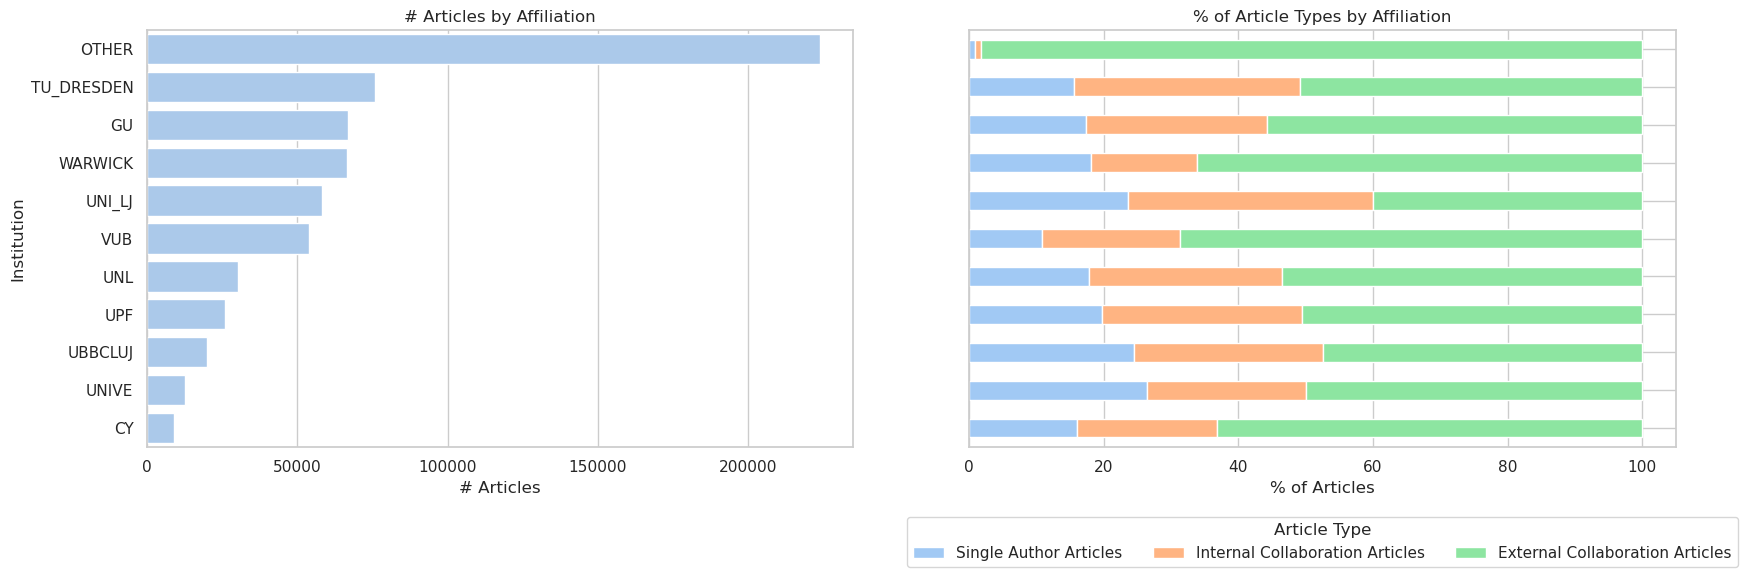

In [5]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Total Articles Plot
sns.barplot(ax=axes[0], data=institution_df, x='total_articles', y='institution_id')
axes[0].set_title('# Articles by Affiliation')
axes[0].set_xlabel('# Articles')
axes[0].set_ylabel('Institution')

# 100% Stacked Bar Plot
institution_df[['Single Author Articles', 'Internal Collaboration Articles', 'External Collaboration Articles']].plot(
    kind='barh', stacked=True, ax=axes[1])
axes[1].set_title('% of Article Types by Affiliation')
axes[1].set_xlabel('% of Articles')
axes[1].set_ylabel('Affiliation')
legend = axes[1].legend(title='Article Type', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.tight_layout()
plt.show()

## Collaboration funnel

We want to show the number of articles in a funnel visualization. We show the total number of articles, how many of them are collaborations, how many of them are EUTOPIAan collaborations and how many of them are both. 

The number of articles is defined as the number of unique DOIs in the dataset.

### Process the data

1. Query the data from BigQuery
2. Extract the values for the funnel visualization

In [6]:
# Define the SQL query
sql_query = f"""
SELECT COUNT(DISTINCT article_id)                  AS total_articles
     , COUNT(DISTINCT CASE
                          WHEN is_external_collaboration OR is_internal_collaboration
                              THEN article_id END) AS article_collaborations
     , COUNT(DISTINCT CASE
                          WHEN is_external_collaboration AND is_external_collaboration
                              THEN article_id END) AS article_external_collaborations
     , COUNT(DISTINCT CASE
                          WHEN is_external_collaboration AND is_external_collaboration AND is_eutopia_collaboration
                              THEN article_id END) AS eutopian_collaboration_articles
FROM fct_collaboration
"""

# Execute the query and store the result in a DataFrame
funnel_df = query(conn=pg_conn, query_str=sql_query)

# Extract the values for funnel visualization
values = funnel_df.iloc[0].tolist()
labels = ["Articles", "Collaborations", "External collaborations",
          "EUTOPIA collaborations"]

### Plotting
We plot the funnel visualization using a horizontal bar chart. We invert the y-axis to have the largest bar on top and add labels to the bars.

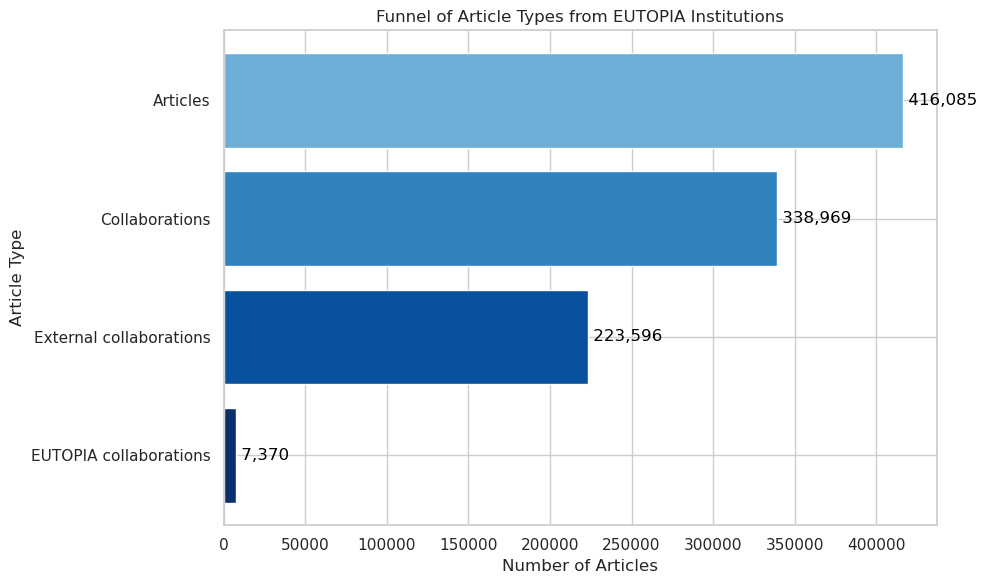

In [7]:
# Funnel Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar chart
ax.barh(labels, values, color=['#6baed6', '#3182bd', '#08519c', '#08306b'])

# Invert y-axis to have the largest bar on top
ax.invert_yaxis()

# Add labels to the bars
for index, value in enumerate(values):
    ax.text(value, index, f' {value:,}', va='center', ha='left', color='black')

# Add title and labels
plt.title('Funnel of Article Types from EUTOPIA Institutions')
plt.xlabel('Number of Articles')
plt.ylabel('Article Type')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Publication trends
We want to show the publication trends of EUTOPIA institutions. We show:
1. how many articles have been published by EUTOPIA institutions each year,
2. how many of them have been collaborations and
3. how EUTOPIA-an collaborations are trending.

### Process the data
1. Query the data from BigQuery

In [8]:
# Define the SQL query
sql_query = f"""
SELECT EXTRACT(YEAR FROM article_publication_dt)                                    AS year
     , COUNT(DISTINCT article_id)                                                   AS total_articles
     , COUNT(DISTINCT CASE
                          WHEN is_internal_collaboration OR IS_EXTERNAL_COLLABORATION
                              THEN article_id END)                                  AS collaboration_articles
     , COUNT(DISTINCT CASE WHEN is_internal_collaboration THEN article_id END)      AS internal_collaboration_articles
     , COUNT(DISTINCT CASE WHEN is_external_collaboration THEN article_id END)      AS external_collaboration_articles
     , COUNT(DISTINCT CASE WHEN is_eutopia_collaboration THEN article_id END)       AS eutopian_collaboration_articles
     , COUNT(DISTINCT CASE WHEN is_single_author_collaboration THEN article_id END) AS single_author_articles
FROM fct_collaboration
WHERE EXTRACT(YEAR FROM article_publication_dt) >= 2000
GROUP BY 1
"""
# Execute the query and store the result in a DataFrame
trend_df = query(conn=pg_conn, query_str=sql_query)

# Convert YEAR to integer for better plotting
trend_df['year'] = trend_df['year'].astype(int)
trend_df.sort_values('year', inplace=True, ascending=True)

### Plotting
We plot the publication trends of EUTOPIA institutions using two subplots. The first subplot shows the total number of articles and the number of collaboration articles each year. The second subplot shows the number of EUTOPIAan collaboration articles each year.

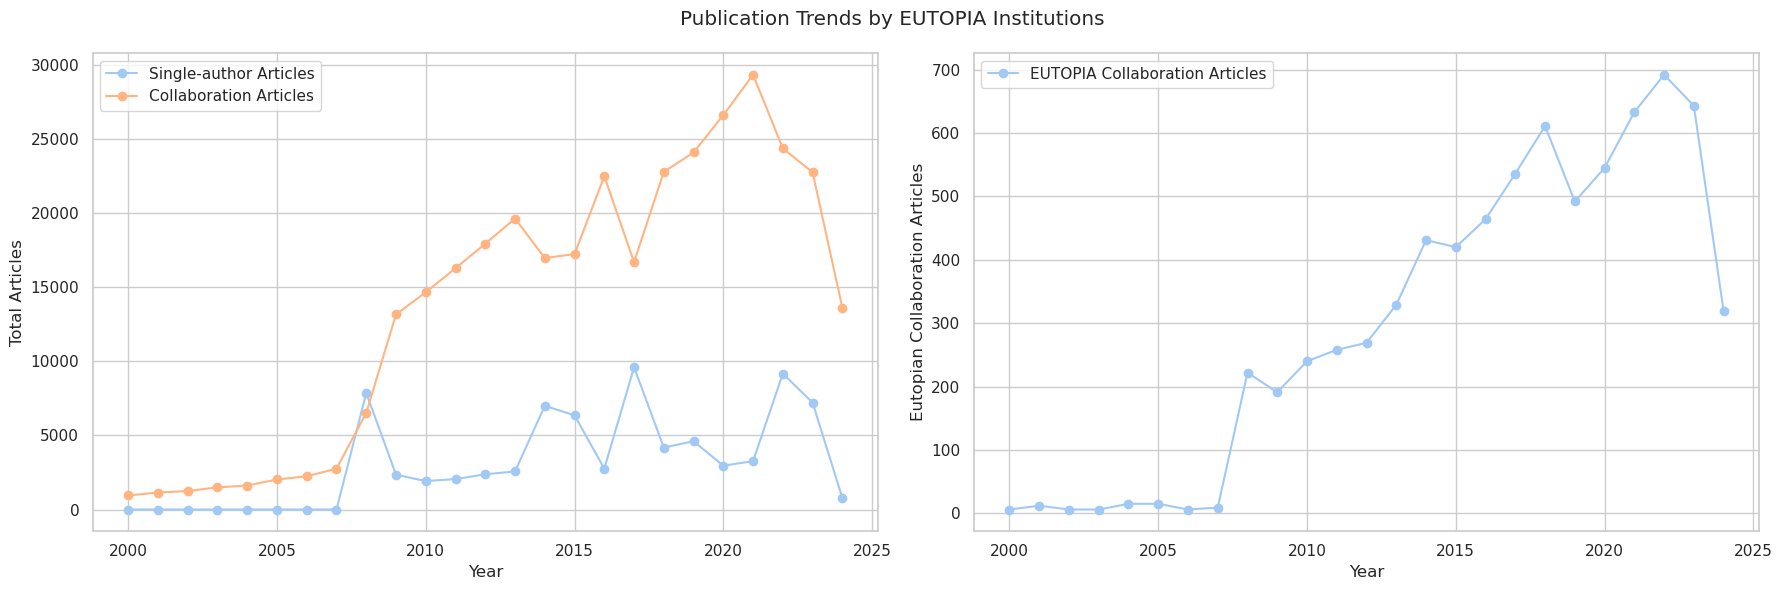

In [9]:
# Set up the plot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First subplot for Total Articles
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Articles')
ax1.plot(trend_df['year'], trend_df['single_author_articles'], label='Single-author Articles', marker='o')
ax1.plot(trend_df['year'], trend_df['collaboration_articles'], label='Collaboration Articles', marker='o')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Second subplot for Eutopian Collaboration Articles
color = 'tab:green'
ax2.set_xlabel('Year')
ax2.set_ylabel('Eutopian Collaboration Articles')
ax2.plot(trend_df['year'], trend_df['eutopian_collaboration_articles'], label='EUTOPIA Collaboration Articles',
         marker='o')
ax2.tick_params(axis='y')
ax2.legend(loc='upper left')

# Title and show
plt.suptitle('Publication Trends by EUTOPIA Institutions')
# Adjust layout
plt.tight_layout()
plt.show()

## Base overview plot

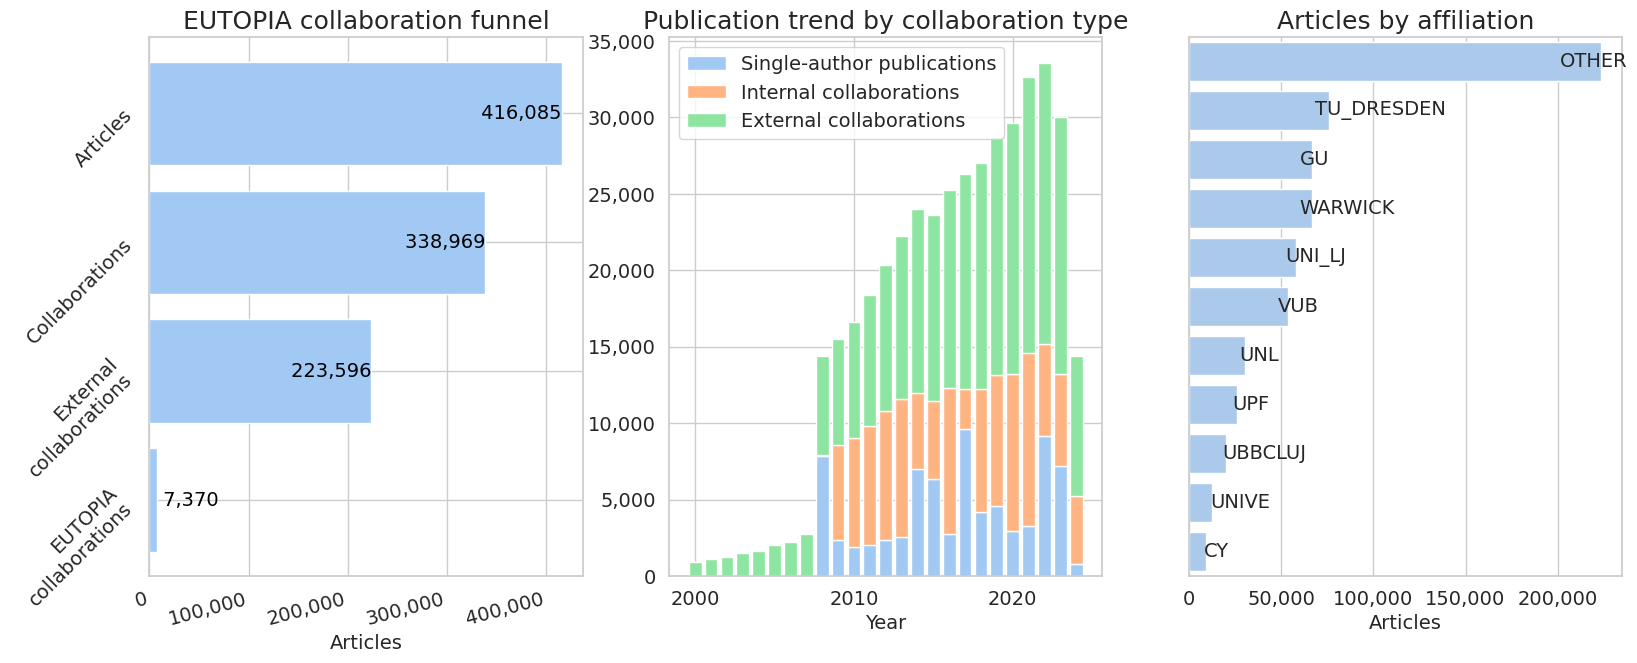

In [13]:
from matplotlib import ticker
plt.rcParams.update({
    'font.size': 14,          # Global font size
    'axes.titlesize': 18,     # Title font size
    'axes.labelsize': 14,     # X and Y label font size
    'xtick.labelsize': 14,    # X tick label font size
    'ytick.labelsize': 14,    # Y tick label font size
    'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 18    # Figure title font size
})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 7))

institution_sorted_df = institution_df.sort_values(by='total_articles', ascending=False)
institution_sorted_df['institution_id'] = institution_sorted_df.index
# Create the horizontal bar plot
sns.barplot(ax=ax3, data=institution_sorted_df, 
            x='total_articles', y='institution_id')

# Set title and labels
ax3.set_title('Articles by affiliation')
ax3.set_xlabel('Articles')
ax3.set_ylabel('')

# Add labels inside the bars
for index, value in enumerate(institution_sorted_df['total_articles']):
    label = institution_sorted_df['institution_id'].iloc[index]
    ax3.text(value * 0.9, index, label, va='center', ha='left')

# Rotate y-axis labels
ax3.set_yticklabels([])
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Publication trend by collaboration type
# Define the width of the bars
bar_width = 0.8

# Plot the stacked bars
ax2.bar(trend_df['year'], trend_df['single_author_articles'], label='Single-author publications',
        width=bar_width)
ax2.bar(trend_df['year'], trend_df['internal_collaboration_articles'], label='Internal collaborations',
        bottom=trend_df['single_author_articles'], width=bar_width)
ax2.bar(trend_df['year'], trend_df['external_collaboration_articles'], label='External collaborations',
        bottom=trend_df['single_author_articles'] + trend_df['internal_collaboration_articles'],
        width=bar_width)

# Set labels and title
ax2.set_xlabel('Year')
ax2.set_ylabel('')
ax2.set_title('Publication trend by collaboration type')

# Rotate x-ticks if necessary (optional)
years = trend_df['year']
every_tenth_year = years[::10]  # Select every 10th year
ax2.set_xticks(every_tenth_year)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add a legend
ax2.legend(loc='upper left')

# EUTOPIA collaboration funnel#

labels = ['Articles', 'Collaborations', 'External\ncollaborations', 'EUTOPIA\ncollaborations']
# Create a horizontal bar chart
(ax1
 .barh(labels, values))
# Invert y-axis to have the largest bar on top
(ax1
 .invert_yaxis())
# Add labels to the bars
for index, (label, value) in enumerate(zip(labels, values)):
    ha = 'left' if label == 'EUTOPIA\ncollaborations' else 'right'
    (ax1
     .text(value, index, f' {value:,}', va='center', ha=ha, color='black'))
# Add title and labels
(ax1
 .set_title('EUTOPIA collaboration funnel'))
(ax1
 .set_xlabel('Articles'))

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.setp(ax1.get_xticklabels(), rotation=15, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=45, ha='right')

# Show plot
plt.savefig('../assets/report_figures/publication_landscape_overview.png')
plt.show()